In [1]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    import pandas as pd
    import pandas_datareader.data as web
    import pickle 
    import requests
    import tensorflow as tf
    import os

C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\kenneth\Anaconda3\envs\gpu\lib\site-packages\tensorflow\python\f

In [2]:
image_path = 'D:/kenneth/agent/images/'
ticker = '^GSPC'
start=('2019-01-01')
end=('2019-12-31')
df=web.DataReader(ticker,'yahoo',start,end)
df.to_csv(ticker+'.csv')
#df = pd.read_csv('D:/kenneth/agent/'+ticker+'.csv', index_col=0, parse_dates=True)

#  Agents

* Turtle Trading agent
* Moving Average agent
* Signal Rolling agent
* Policy Gradient agent
* Q-learning agent
* Evolution Strategy agent
* Double Q-learning agent
* Recurrent Q-learning agent
* Double Recurrent Q-learning agent
* Duel Q-learning agent
* Double Duel Q-learning agent
* Duel Recurrent Q-learning agent
* Double Duel Recurrent Q-learning agent
* Actor-critic agent
* Actor-critic Duel agent
* Actor-critic Recurrent agent
* Actor-critic Duel Recurrent agent
* Curiosity Q-learning agent
* Recurrent Curiosity Q-learning agent
* Duel Curiosity Q-learning agent
* Neuro-evolution agent
* Neuro-evolution with Novelty search agent
* ABCD strategy agent
* Deep Evolution Strategy

## ABCD strategy agent

In [3]:

name = 'ABCD strategy agent'

def abcd(trend, skip_loop = 4, ma = 7):
    ma = pd.Series(trend).rolling(ma).mean().values
    x = []
    for a in range(ma.shape[0]):
        for b in range(a, ma.shape[0], skip_loop):
            for c in range(b, ma.shape[0], skip_loop):
                for d in range(c, ma.shape[0], skip_loop):
                    if ma[b] > ma[a] and \
                    (ma[c] < ma[b] and ma[c] > ma[a]) \
                    and ma[d] > ma[b]:
                        x.append([a,b,c,d])
    x_np = np.array(x)
    ac = x_np[:,0].tolist() + x_np[:,2].tolist()
    bd = x_np[:,1].tolist() + x_np[:,3].tolist()
    ac_set = set(ac)
    bd_set = set(bd)
    signal = np.zeros(len(trend))
    buy = list(ac_set - bd_set)
    sell = list(list(bd_set - ac_set))
    signal[buy] = 1.0
    signal[sell] = -1.0
    return signal

In [4]:
%%time
signal = abcd(df['Close'])

Wall time: 1.16 s


In [5]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 10000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    states_money = []
    current_inventory = 0
    
    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory
    
    for i in range(real_movement.shape[0]):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
        states_money.append(initial_money)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest, states_money

In [6]:
states_buy, states_sell, total_gains, invest, states_money = buy_stock(df.Close, signal)

day 6: buy 1 units at price 2596.639893, total balance 7403.360107
day 7: buy 1 units at price 2596.260010, total balance 4807.100098
day 8: buy 1 units at price 2582.610107, total balance 2224.489990
day 9: total balances 2224.489990, not enough money to buy a unit price 2610.300049
day 10: total balances 2224.489990, not enough money to buy a unit price 2616.100098
day 11: total balances 2224.489990, not enough money to buy a unit price 2635.959961
day 12: total balances 2224.489990, not enough money to buy a unit price 2670.709961
day 13: total balances 2224.489990, not enough money to buy a unit price 2632.899902
day 14: total balances 2224.489990, not enough money to buy a unit price 2638.699951
day 15: total balances 2224.489990, not enough money to buy a unit price 2642.330078
day 16: total balances 2224.489990, not enough money to buy a unit price 2664.760010
day 17: total balances 2224.489990, not enough money to buy a unit price 2643.850098
day 18: total balances 2224.489990,

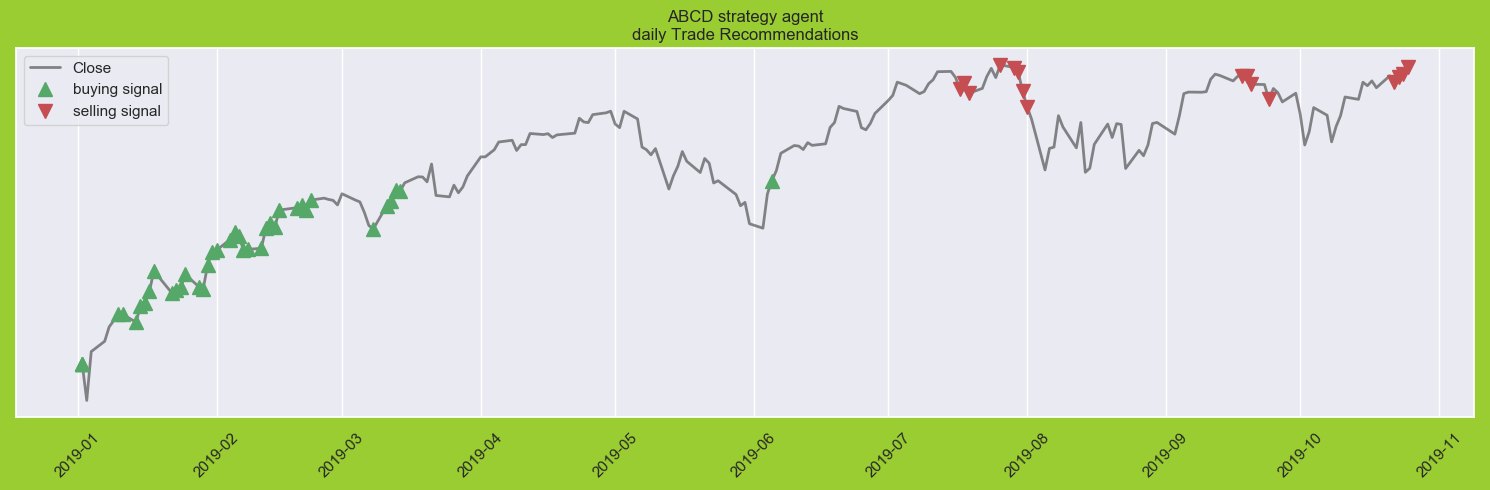

In [7]:
close = df['Close']
fig = plt.figure(figsize = (15,5), facecolor='yellowgreen', dpi=100)
plt.plot(close, color='k', lw=2., alpha=0.5)
plt.plot(close, '^', markersize=10, color='g', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='r', label = 'selling signal', markevery = states_sell)
plt.title(name+'\n'+'daily Trade Recommendations')
plt.legend()
plt.xticks(rotation=45)
plt.gca().axes.get_yaxis().set_visible(False)
fig.tight_layout()
plt.savefig('images/'+ticker+name+'.png', facecolor='yellowgreen', dpi=100)
plt.show()

In [8]:
display_days = 30
total_days= df.shape[0]
display_from = total_days-display_days

In [9]:
new_buy = []
for i in(states_buy):
    if i > display_from:
        adj = i- display_from
        new_buy.append(adj)
new_buy

[]

In [10]:
new_sell = []
for i in(states_sell):
    if i > display_from:
        adj = i- display_from
        new_sell.append(adj)
new_sell

[2, 3, 4, 6, 26, 27, 28, 29]

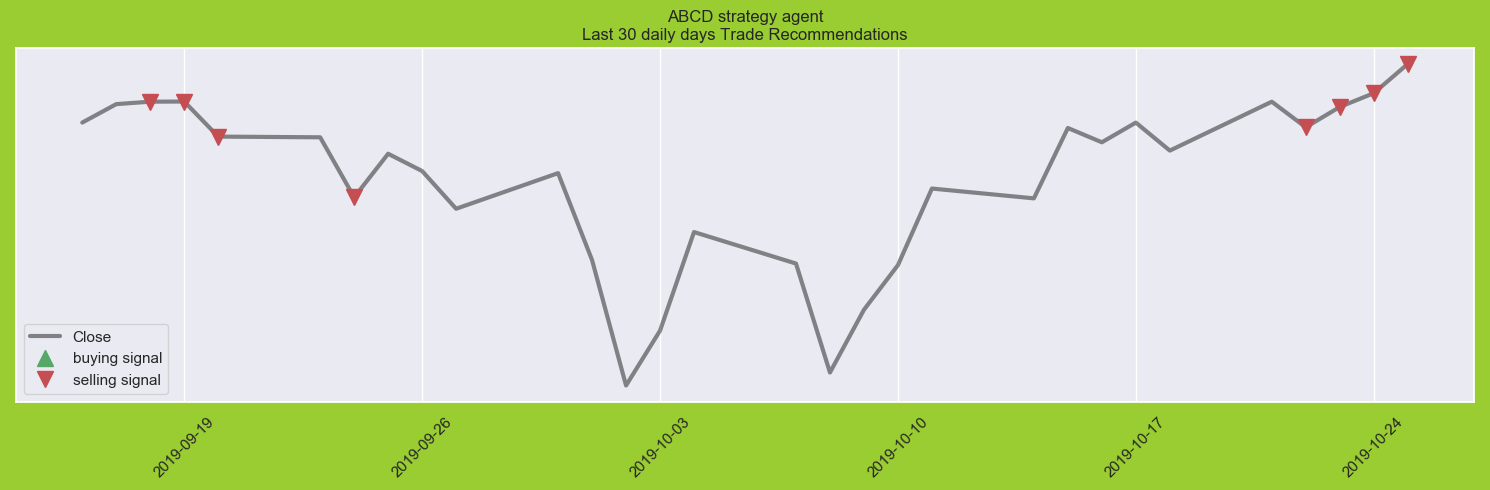

In [11]:
close = df['Close'][-display_days:]
fig = plt.figure(figsize = (15,5), facecolor='yellowgreen', dpi=100)
plt.plot(close, color='k', lw=3., alpha=0.5)
plt.plot(close, '^', markersize=12, color='g',alpha=1.0,label = 'buying signal', markevery = new_buy)
plt.plot(close, 'v', markersize=12, color='r',alpha=1.0, label = 'selling signal', markevery = new_sell)
plt.title(name+'\n'+'Last '+str(display_days)+' daily days Trade Recommendations')
plt.xticks(rotation=45)
plt.legend()
plt.gca().axes.get_yaxis().set_visible(False)
fig.tight_layout()
#plt.savefig('images/'+ticker+name+'.png', facecolor='yellowgreen', dpi=100)
plt.show()